# 第十三週：LLM Information Extraction
本周課程為「LLM Information Extraction」，主要會使用到 Langchian 套件與 HuggingFace 模型來實作
1. Open LLM Inference
2. Prompt Engineering
3. Information Extraction(Sentiment classification, NER)

### 大綱：
1. LLM inference 基本範例
    * Langchian 介紹
      * Chain
        * LCEL (LangChain Expression Language)
        * RunnableSequence
        * RunnableParallel
      * Prompt templete
        * PromptTemplate
        * ChatPromptTemplate
          * System prompt
          * User prompt
      * Output parser
    * Inference

2. Prompt engineering
    * Few-shot
    * CoT
    * Self-consistency

3. 資料集實作 Information Extraction (Tagging)
    * 句子情緒判別 Sentiment Classification (Positive, Neutral, Negative)
    * NER

4. Retrieve QA (RAG)
    * 學校選課規範

# 參考資料
- https://python.langchain.com/docs/integrations/llms/huggingface_endpoint/

# 套件安裝

In [177]:
# !pip install sentence-transformers
# !pip install langchain-chroma
# !pip install pypdf
# !pip install langchain
# !pip install huggingface_hub
# !pip install grandalf
# !pip install pandas

In [276]:
import os
from getpass import getpass

import pandas as pd
import ast
import json
import re

from langchain_community.llms import HuggingFaceEndpoint

from langchain_core.prompts import PromptTemplate
from langchain_core.prompts import ChatPromptTemplate

from langchain_core.runnables import RunnablePassthrough
from langchain_core.runnables import RunnableParallel
from langchain_core.runnables import RunnableLambda

from langchain_core.output_parsers import JsonOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field

from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_community.embeddings.sentence_transformer import (
    SentenceTransformerEmbeddings,
)

# 連線 Google Drive

In [ ]:
# import os

# from google.colab import drive
# drive.mount('/content/drive')

# os.chdir('你的雲端資料夾路徑') #切換該目錄
# os.listdir() #確認目錄內容

# HuggingFace Token

輸入 HuggingFace Token
- get a token: https://huggingface.co/docs/api-inference/quicktour#get-your-api-token

In [7]:
HUGGINGFACEHUB_API_TOKEN = getpass()
os.environ["HUGGINGFACEHUB_API_TOKEN"] = HUGGINGFACEHUB_API_TOKEN

本範例使用 gemma 7b instruct 版本
- huggingface: https://huggingface.co/google/gemma-1.1-7b-it

In [51]:
# 使用的模型 huggingface ID
repo_id = "google/gemma-1.1-7b-it"

# 1. LLM inference 基本範例

## Langchian 介紹
- 專門用來開發語言模型(Language Model)相關應用的框架(framework)
- 讓開發者整合不同的語言模型，開發像 ChatGPT, 聊天機器人、數位助理等等應用程式

<img src="https://python.langchain.com/v0.1/svg/langchain_stack.svg" width="50%"><img src="https://wangwei1237.github.io/2023/09/20/Introduction-to-LangChain/langchain.png" width="50%">
- **LangChain Libraries LangChain**: 相關的功能與 API 等等，支援 Python 與 JavaScript
- **LangChain Templates**: 一些常見的 LangChain 模板(templates)，讓開發者可以套用，省去重新開發的成本
- **LangServe**: 可以將 LangChain 的 chain 開發成 REST API 的部件
- **LangSmith**: 讓開發者對語言模型進行測試、評估、除錯、監控等行為的 1 個平台


### 基本詢問

In [144]:
# repo_id: HuggingFace 上的模型名稱
# temperature: 模型回答的活潑程度，0~1 越大每次回答的多樣性越高

llm = HuggingFaceEndpoint(
    repo_id=repo_id, temperature=0.7, cache=False, token=HUGGINGFACEHUB_API_TOKEN
)
llm.invoke("請問周杰倫是誰？")

WARNING! token is not default parameter.
                    token was transferred to model_kwargs.
                    Please make sure that token is what you intended.


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /home/zchenchen1999/.cache/huggingface/token
Login successful


'\n\n周杰倫是**一位台灣流行音樂歌手和詞曲作家**。他以其獨特的曲風和詞曲而聞名，並被譽為**「現代流行音樂的代表人物」**。'

### Chain
- LCEL (LangChain Expression Language)
    - 官網介紹：https://python.langchain.com/v0.1/docs/expression_language/why/
    - Langchain 說明：LCEL 可以讓我們更簡單的開發複雜的 chain 應用，可以支援：Streaming, Parallelism, logging。
    - 為了簡單化，LCEL 有兩的主要功能
        1. 統一的協定(Protocol)：所有的 LCEL object 都要遵照 Runnable interface，簡單來說都要包含以下方法，來讓多個 LCEL object 之間可以 chain(鏈結起來):
            1. invoke (支援單一輸入、單一輸出）
            2. batch (支援多個輸入、多個輸出）
            3. stream (支援有部分結果就輸出的模式)
            4. ainvoke (async 版本的 invoke)
            5. abatch (async 版本的 batch)
            6. astream (async 版本的 stream)
            
            - LCEL object:
                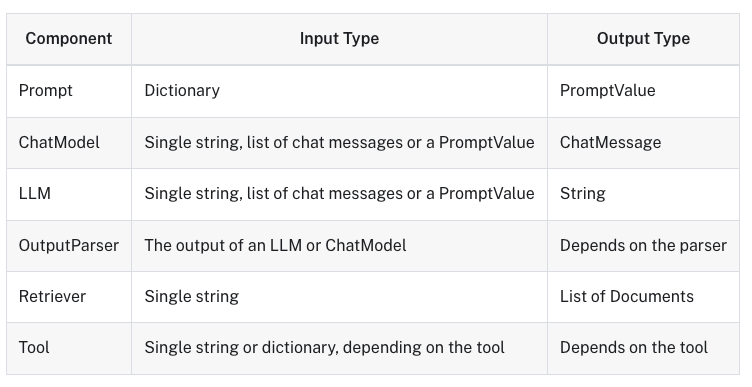
            
            - 詳細定義：
                1. https://api.python.langchain.com/en/stable/runnables/langchain_core.runnables.base.Runnable.html#langchain_core.runnables.base.Runnable
                2. https://python.langchain.com/v0.1/docs/expression_language/interface/
        2. 組合語言：讓 chain 的組合更容易
            - 提供不同元件組合的功能，使用 "|" 將不同元件串在一起，例如：prompt | llm
- Chain 精神
    - 可重複執行
    - 可自由組合
    - 有兩種主要的型態
        1. RunnableSequence: 依序執行每個 Runnable
        2. RunnableParallel: 同時執行 Runnable

#### RunnableSequence
- 依序執行每個 Runnable
- 使用 "|" 連結

In [65]:
template = """你是一位聰明的 AI 助手，將會幫使用者解答以下問題: {question}"""

prompt = PromptTemplate.from_template(template)

prompt_output = prompt.invoke({"question": '請問如何選擇晚餐要吃什麼？'})
prompt_output

StringPromptValue(text='你是一位聰明的 AI 助手，將會幫使用者解答以下問題: 請問如何選擇晚餐要吃什麼？')

In [66]:
print(prompt_output)
llm_output = llm.invoke(prompt_output)
llm_output

text='你是一位聰明的 AI 助手，將會幫使用者解答以下問題: 請問如何選擇晚餐要吃什麼？'


'\n\n晚餐選擇可以根據個人喜好和營養需求進行。以下是一些建議：\n\n* **考慮個人喜好:** 你喜歡什麼？你對哪種食物感到滿意？\n* **考慮營養需求:** 你需要攝入多少碳水化合物、蛋白質和脂肪？\n* **考慮飲食習慣:** 你是否有任何飲食限制或偏好？\n* **考慮時間和材料:** 你有幾分鐘時間準備晚餐？你有什麼食材在手？\n\n**根據以上建議，如何選擇晚餐要吃什麼？**\n\n**步驟 1：考慮個人喜好**\n\n* 列出你喜歡的美食和食物類型。\n* 考慮你對哪種食物感到滿意。\n\n**步驟 2：考慮營養需求**\n\n* 確定你的碳水化合物、蛋白質和脂肪需求。\n* 選擇含有這些營養素的食物。\n\n**步驟 3：考慮飲食習慣**\n\n* 列出任何飲食限制或偏好。\n* 選擇適合你的食物。\n\n**步驟 4：考慮時間和材料**\n\n* 考慮你有幾分鐘時間準備晚餐。\n* 考慮你有哪些食材在手。\n\n**步驟 5：結合所有因素**\n\n* 將所有因素考慮起來，選擇適合你的晚餐。'

In [71]:
# RunnablePassthrough: 可以不變的傳遞整個 input

template = """你是一位聰明的 AI 助手，將會幫使用者解答以下問題: {question}"""

prompt = PromptTemplate.from_template(template)

chain = (
    {"question": RunnablePassthrough()} 
    | prompt
    | llm
)
chain.invoke("日式料理好吃嗎？")

'\n\n**解答：**\n\n日式料理因其獨特的香氣和風味而著稱。日式料理以鮮度高、風味鮮豔的食材著稱，並以簡潔、精緻的烹飪技術著稱。日式料理的風味非常豐富，從鮮香的魚肉到香氣濃郁的香料。總之，日式料理好吃。'

#### RunnableParallel

In [78]:
def add_one(value: dict) -> int:
    return value['x'] * value['y']

template = """你是一位數學家，將會幫使用者解答以下數學問題: {x}*{y}?"""
prompt = PromptTemplate.from_template(template)

runnable_1 = RunnableLambda(add_one)
runnable_2 = (
    RunnablePassthrough() 
    | prompt
    | llm
)

parallel = {"runnable_1": runnable_1, "runnable_2": runnable_2}

chain = RunnableLambda(lambda x: x) | parallel
answer = chain.invoke({'x':1, 'y':2})

print(answer)

{'runnable_1': 2, 'runnable_2': '\n\n**解答：2**\n\n乘法運算的結果為 1 * 2 = 2。'}


In [82]:
chain = RunnableParallel(ground_truth=runnable_1, LLM=runnable_2)
chain.invoke({'x':3, 'y':4})

{'ground_truth': 12, 'LLM': '\n\n**答案：**\n\n3 * 4 = 12。'}

### Prompt templete
- 官網：https://python.langchain.com/v0.1/docs/modules/model_io/prompts/quick_start/
- Prompt templete 可以預先定義一個要輸入給 LLM 的文字模板
- Langchian 提供了建立 prompt templete 的工具
- 通常有兩種型態：
    1. PromptTemplate: string
    2. ChatPromptTemplate: list of chat messages （適用 chat model: A chat model is a language model that uses chat messages as inputs and returns chat messages as outputs (as opposed to using plain text).）

#### PromptTemplate: string

In [104]:
template = """Question: {question}

Answer: Let's think step by step."""

prompt_template = PromptTemplate.from_template(template)

# 可以透過 .input_schema.schema() 查看 templete 有哪一些變數需要輸入
print(prompt_template.input_schema.schema())

# format 可以將變數輸入進去後查看完整的 prompt 長相
prompt_template.format(question="Who won the FIFA World Cup in the year 1994? ")

{'title': 'PromptInput', 'type': 'object', 'properties': {'question': {'title': 'Question', 'type': 'string'}}}


"Question: Who won the FIFA World Cup in the year 1994? \n\nAnswer: Let's think step by step."

In [111]:
# PromptTemplate 也是 implement Runnable interface，所以一樣可以使用 invoke
prompt = prompt_template.invoke({"question": "Who won the FIFA World Cup in the year 1994? "})
print(prompt)
prompt.to_string()

text="Question: Who won the FIFA World Cup in the year 1994? \n\nAnswer: Let's think step by step."


"Question: Who won the FIFA World Cup in the year 1994? \n\nAnswer: Let's think step by step."

#### ChatPromptTemplate: list of chat messages
- 內容為 chat message，當中有 "role" 角色的概念，讓 LLM 了解內容是什麼角色說的
- system: 這個role負責的是類似系統設定的文字提示，例如跟 LLM 說他是一個工程師，接下來要請他用他的專業寫 code；或是跟 LLM 說他是一個厲害的數學家，要請他用他的專業解題。
- user: 使用者說的話，例如問 LLM 的問題。

In [106]:
chat_template = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a helpful AI bot. Your name is {name}."),
        ("human", "Hello, how are you doing?"),
        ("ai", "I'm doing well, thanks!"),
        ("human", "{user_input}"),
    ]
)
print(chat_template.input_schema.schema())
messages = chat_template.format_messages(name="Bob", user_input="What is your name?")
messages

{'title': 'PromptInput', 'type': 'object', 'properties': {'name': {'title': 'Name', 'type': 'string'}, 'user_input': {'title': 'User Input', 'type': 'string'}}}


[SystemMessage(content='You are a helpful AI bot. Your name is Bob.'),
 HumanMessage(content='Hello, how are you doing?'),
 AIMessage(content="I'm doing well, thanks!"),
 HumanMessage(content='What is your name?')]

In [110]:
chat_prompt = chat_template.invoke({"name": "Bob", "user_input":"What is your name?"})
print(chat_prompt)
prompt.to_string()

messages=[SystemMessage(content='You are a helpful AI bot. Your name is Bob.'), HumanMessage(content='Hello, how are you doing?'), AIMessage(content="I'm doing well, thanks!"), HumanMessage(content='What is your name?')]


"Question: Who won the FIFA World Cup in the year 1994? \n\nAnswer: Let's think step by step."

Tips: 因為 {} 在 prompt templete 中代表變數輸入的位置，如果在文字中有需要用到大括號，請使用 "{{" 及 "}}"

### Output Parser
- 官網：https://python.langchain.com/v0.1/docs/modules/model_io/output_parsers/
- Output Parser 目的是要讓 LLM 生成的內容符合特定格式，例如：JSON, list, YAML 等
- Tips: LLM 生成式模型無法 100% 照著想要輸出的格式走，在使用時也要考慮到模型的能力。

以 JSON 為例

In [120]:
# 使用 Pydantic 來宣告資料型態
# Define your desired data structure.
class Joke(BaseModel):
    setup: str = Field(description="question to set up a joke")
    punchline: str = Field(description="answer to resolve the joke")

parser = JsonOutputParser(pydantic_object=Joke)

# 透過 get_format_instructions() 可以看到如何告訴 LLM 生成我們想要的格式的一些指令
parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"setup": {"title": "Setup", "description": "question to set up a joke", "type": "string"}, "punchline": {"title": "Punchline", "description": "answer to resolve the joke", "type": "string"}}, "required": ["setup", "punchline"]}\n```'

In [135]:
# And a query intented to prompt a language model to populate the data structure.
joke_query = "Tell me a joke."

# Set up a parser + inject instructions into the prompt template.
parser = JsonOutputParser(pydantic_object=Joke)

prompt = PromptTemplate(
    template="Answer the user query.\n{format_instructions}\n\n{query}\n",
    # template="Answer the user query.\n{format_instructions}\nDon't output any other explanation\n{query}\n",
    input_variables=["query"],
    # 將 format_instructions 也輸入到 prompt templete 中
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

chain = prompt | llm | parser

answer = chain.invoke({"query": joke_query})

In [136]:
print(answer)
print(answer["setup"])
print(answer["punchline"])

{'setup': 'What did the golfer say when he lost his club?', 'punchline': "I can't seem to iron this out!"}
What did the golfer say when he lost his club?
I can't seem to iron this out!


In [140]:
# 查看 chain 架構
chain.get_graph().print_ascii()

      +-------------+      
      | PromptInput |      
      +-------------+      
             *             
             *             
             *             
    +----------------+     
    | PromptTemplate |     
    +----------------+     
             *             
             *             
             *             
  +---------------------+  
  | HuggingFaceEndpoint |  
  +---------------------+  
             *             
             *             
             *             
   +------------------+    
   | JsonOutputParser |    
   +------------------+    
             *             
             *             
             *             
+------------------------+ 
| JsonOutputParserOutput | 
+------------------------+ 


# 2. Prompt engineering
- Prompt 的設計有很大程度會影響 LLM 的輸出，甚至影響 LLM 整體能力，以下會介紹幾個常用的 prompt 技巧
    1. Few-shot
    2. Chain of thought(CoT)
    3. Self-consistency

<start_of_turn>user
Answer the following question in a concise and informative manner:
 
Explain why the sky is blue<end_of_turn>
<start_of_turn>model

In [172]:
template = """<start_of_turn>user
你是一位數學家，將會幫助回答數學問題。

問題：{question}<end_of_turn>
<start_of_turn>model
答案："""

prompt = PromptTemplate.from_template(template)

chain = (
    {"question": RunnablePassthrough()} 
    | prompt
    | llm
)
chain.invoke("當我六歲的時候，我姐姐的年齡只有我的一半。 現在我70歲了，我姐姐幾歲了？")

'**50歲**\n\n**解法：**\n\n1. 設我現在的年齡為x歲。\n2. 那麼我姐姐在六歲時比我大x/2歲。\n3. 因此，我姐姐現在的年齡為x + x/2 = 3x/2歲。\n4. 因為我現在70歲，所以：\n   3x/2 = 70\n5. 解出x，得到：\n   x = 70 * 2/3 = 46.67歲。\n\n因此，我姐姐現在有**46.67歲**。'

## Few-shot

In [173]:
template = """<start_of_turn>user
你是一位數學家，將會幫助回答數學問題。

以下為一些例子：
```
問題：當我九歲的時候，我弟弟的年齡是我的三分之二。現在我54歲了，我弟弟幾歲了？
答案：51歲

問題：當我八歲的時候，我妹妹的年齡是我的四分之一。現在我48歲了，我妹妹幾歲了？
答案：42歲
```

現在請回答以下問題
問題：{question}<end_of_turn>
<start_of_turn>model
答案："""

prompt = PromptTemplate.from_template(template)

chain = (
    {"question": RunnablePassthrough()} 
    | prompt
    | llm
)
chain.invoke("當我六歲的時候，我姐姐的年齡只有我的一半。 現在我70歲了，我姐姐幾歲了？")

'65歲\n\n解析：\n\n假設六歲時的姐姐的年齡為x歲。\n則：x = (70-6)/2 = 65歲。'

## Chain of thought(CoT)

In [174]:
template = """<start_of_turn>user
你是一位數學家，將會幫助回答數學問題。

以下為一些例子：
```
例子1:
問題：當我九歲的時候，我弟弟的年齡是我的三分之二。現在我54歲了，我弟弟幾歲了？
答案：我們一步一步來計算。

當你九歲的時候，你弟弟的年齡是你的三分之二：

你9歲時，你弟弟是 9x(2/3) = 6歲。
現在你54歲了：

你比當時大了45歲（54 - 9 = 45）。
因此，你弟弟現在也比當時大了45歲。
計算你弟弟的年齡：

你弟弟當時6歲，現在他比當時大45歲，所以他現在是6 + 45 = 51歲。
所以，你弟弟現在51歲。


例子2:
問題：當我八歲的時候，我妹妹的年齡是我的四分之一。現在我48歲了，我妹妹有一個比她小18歲的女兒。她的女兒幾歲了？
答案：
我們一步一步來計算。

當你八歲的時候，你妹妹的年齡是你的四分之一：

你8歲時，你妹妹是 8*(1/4)=2 歲。
現在你48歲了：

你比當時大了40歲（48 - 8 = 40）。
因此，你妹妹現在也比當時大了40歲。
計算你妹妹的年齡：

你妹妹當時2歲，現在她比當時大40歲，所以她現在是2 + 40 = 42歲。
```

現在請回答以下問題
問題：{question}<end_of_turn>
<start_of_turn>model
答案："""

prompt = PromptTemplate.from_template(template)

chain = (
    {"question": RunnablePassthrough()} 
    | prompt
    | llm
)
chain.invoke("當我六歲的時候，我姐姐的年齡只有我的一半。 現在我70歲了，我姐姐有一個比她小25歲的兒子。 她兒子幾歲了？")

'\n\n我們一步一步來計算。\n\n當你六歲的時候，你姐姐的年齡是你的半：\n\n你6歲時，你姐姐是 6/2 = 3歲。\n現在你70歲了：\n\n你比當時大了64歲（70 - 6 = 64）。\n因此，你姐姐現在也比當時大了64歲。\n計算你姐姐的年齡：\n\n你姐姐當時3歲，現在她比當時大64歲，所以她現在是3 + 64 = 67歲。\n\n所以，你姐姐現在67歲。'

## Self-consistency

In [ ]:
template = """<start_of_turn>user
你是一位數學家，將會幫助回答數學問題。

以下為一些例子：
```
例子1:
問題：當我九歲的時候，我弟弟的年齡是我的三分之二。現在我54歲了，我弟弟幾歲了？
答案：我們一步一步來計算。

當你九歲的時候，你弟弟的年齡是你的三分之二：

你9歲時，你弟弟是 9x(2/3) = 6歲。
現在你54歲了：

你比當時大了45歲（54 - 9 = 45）。
因此，你弟弟現在也比當時大了45歲。
計算你弟弟的年齡：

你弟弟當時6歲，現在他比當時大45歲，所以他現在是6 + 45 = 51歲。
所以，你弟弟現在51歲。


例子2:
問題：當我八歲的時候，我妹妹的年齡是我的四分之一。現在我48歲了，我妹妹有一個比她小18歲的女兒。她的女兒幾歲了？
答案：
我們一步一步來計算。

當你八歲的時候，你妹妹的年齡是你的四分之一：

你8歲時，你妹妹是 8*(1/4)=2 歲。
現在你48歲了：

你比當時大了40歲（48 - 8 = 40）。
因此，你妹妹現在也比當時大了40歲。
計算你妹妹的年齡：

你妹妹當時2歲，現在她比當時大40歲，所以她現在是2 + 40 = 42歲。
```

現在請回答以下問題
問題：{question}<end_of_turn>
<start_of_turn>model
答案："""

prompt = PromptTemplate.from_template(template)

chain = (
    {"question": RunnablePassthrough()} 
    | prompt
    | llm
)
chain.invoke("當我六歲的時候，我姐姐的年齡只有我的一半。 現在我70歲了，我姐姐有一個比她小25歲的兒子。 她兒子幾歲了？")

# 3. 資料集實作 Information Extraction (Tagging)
- https://python.langchain.com/docs/use_cases/tagging/

In [292]:
df = pd.read_csv("../week3/raw_data/zh_buffet_20_22.csv")
df["artDate"] = pd.to_datetime(df["artDate"])
df['artDate'] = df['artDate'].dt.date 

clear_df = df.copy()

#去除本次不會用到的欄位
drop_cols = ['system_id', 'artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource']
clear_df.drop(drop_cols, axis = 1, inplace = True)

#去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
clear_df['sentence'] = clear_df['artContent'].str.replace(r'\n\n','。', regex=True)
clear_df['sentence'] = clear_df['sentence'].str.replace(r'\n','', regex=True)

#移除內文中的網址
clear_df['sentence'] = clear_df['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

clear_df['sentence'] = clear_df['sentence'].str.split("[,，。！!？?]{1,}")

sent_df = clear_df.explode('sentence').reset_index(drop=True)
# 把長度小於1的sentence刪掉
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

sampled_df = sent_df.sample(n=100, random_state=222)

sampled_df

,artUrl,artTitle,artDate,artContent,sentence
56752,https://www.ptt.cc/bbs/Food/M.1621703754.A.932...,[廣宣]高雄漢來大飯店防疫便當外帶便當,2021-05-23,餐廳名稱：漢來大飯店 防疫便當\n 消費時間：2021年05月\n 店家地址：高雄市...,可能也不道地
27235,https://www.ptt.cc/bbs/Food/M.1598437938.A.19C...,[情報]2020台北米其林餐盤推薦90間懶人包總整,2020-08-26,餐飲名稱：2020台北米其林餐盤推薦餐廳 (共90間)\n\n ============...,以年年都攻下米其林三星的頤宮為例 (圖片節自米其林官方網站)
40751,https://www.ptt.cc/bbs/Food/M.1609600749.A.0D6...,[食記]台北市信義區ATT4FUN海底撈一個人攻略,2021-01-02,餐廳名稱：海底撈火鍋\n 消費時間：2020年/12月\n 地址：110台北市信義區...,不過搭配辣粉配著吃很好吃
40672,https://www.ptt.cc/bbs/Food/M.1609600749.A.0D6...,[食記]台北市信義區ATT4FUN海底撈一個人攻略,2021-01-02,餐廳名稱：海底撈火鍋\n 消費時間：2020年/12月\n 地址：110台北市信義區...,結果吃來吃去
227,https://www.ptt.cc/bbs/Food/M.1578125940.A.9AA...,[食記]長榮皇璽桂冠艙飛機餐SEA-TPE聖誕好運,2020-01-04,店名：長榮皇璽桂冠艙飛機餐\n 地址：無\n 電話：無\n 營業時間：依機艙供餐...,再醒過來的時候已經要吃早餐了
...,...,...,...,...,...
36449,https://www.ptt.cc/bbs/Food/M.1605741098.A.40E...,[食記]台南松井田精緻火鍋24小時營業小火鍋,2020-11-19,餐廳名稱：松井田精緻火鍋\n 消費時間：2020年/11月\n 地址：台南市中西區金...,白飯也是內用吃到飽
44516,https://www.ptt.cc/bbs/Food/M.1612104676.A.649...,[食記]台中中西區逐鹿炭火燒肉燒肉吃到飽,2021-01-31,餐廳名稱：逐鹿炭火燒肉\n 消費時間：2021年/01月\n 地址：台南市中西區環河...,前面排隊要領車的人也是因為吃逐鹿被拖吊
54392,https://www.ptt.cc/bbs/Food/M.1618760532.A.E29...,[食記]高雄上官木桶鍋平實不貴的雙人套餐,2021-04-18,餐廳名稱：上官木桶鍋 高雄裕誠加盟店 （源自蘆洲正官）\n 消費時間：2021年01月\...,當時的價格是五顆生蠔210元
62799,https://www.ptt.cc/bbs/Food/M.1633964063.A.C99...,[食記]新北我家牛排新北中和店,2021-10-11,排餐料理吃到飽系列之--我家牛排新北中和店\n\n有圖有真相圖文並茂版：\nhttps://...,排餐料理吃到飽系列之--我家牛排新北中和店


In [293]:
class Food(BaseModel):
    情緒: str = Field(..., description="判斷整個句子總體的情緒。", enum=["正向", "中性", "負向"])
    食物: str = Field(
        ...,
        description="列出所有句子中提及的食物並以逗號','分隔。"
    )
    料理種類: str = Field(
        ...,
        description="判斷句子中提到的料理是屬於什麼種類的。",
        enum=["日式", "美式", "中式", "泰式", "韓式", "法式", "其他", "無"],
    )

food_parser = JsonOutputParser(pydantic_object=Food)

# 透過 get_format_instructions() 可以看到如何告訴 LLM 生成我們想要的格式的一些指令
food_parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"\\u60c5\\u7dd2": {"title": "\\u60c5\\u7dd2", "description": "\\u5224\\u65b7\\u6574\\u500b\\u53e5\\u5b50\\u7e3d\\u9ad4\\u7684\\u60c5\\u7dd2\\u3002", "enum": ["\\u6b63\\u5411", "\\u4e2d\\u6027", "\\u8ca0\\u5411"], "type": "string"}, "\\u98df\\u7269": {"title": "\\u98df\\u7269", "description": "\\u5217\\u51fa\\u6240\\u6709\\u53e5\\u5b50\\u4e2d\\u63d0\\u53ca\\u7684\\u98df\\u7269\\u4e26\\u4ee5\\u9017\\u865f\',\'\\u5206\\u9694\\u3002", "type": "string"}, "\\u6599\\u7406\\u7a2e\\u985e": {"title": "\\u6599\\u7406\\u7a2e\\u985e

In [294]:
# Set up a parser + inject instructions into the prompt template.
food_parser = JsonOutputParser(pydantic_object=Food)\

food_template = """<start_of_turn>user
你是一位美食評論家，你將會看網路上對於餐廳的評論，請抓取出評論中：
1.此評論的情緒，正向或負向或中性
2.有討論到食物，例如：火鍋、牛排、炒飯
3.料理的流派，例如：日式、中式、美式

以下為一些範例：
```
範例1
句子：再來甜點會進入人體的第二個胃還是必吃
抓取結果：{{
    "情緒":"中性",
    "食物":"甜點",
    "料理種類":"無"
}}

範例2
句子：再到自助區加點蔥花蒜頭一起入口就好美味呀
抓取結果：{{
    "情緒":"正向",
    "食物":"蔥花,蒜頭",
    "料理種類":"無"
}}

範例3
句子：但Woosan韓式烤肉店真的很有吸引力
抓取結果：{{
    "情緒":"正向",
    "食物":"烤肉",
    "料理種類":"韓式"
}}

範例3
句子：普普通通
抓取結果：{{
    "情緒":"中性",
    "食物":"無",
    "料理種類":"無"
}}


{format_instructions}
請使用繁體中文回答。
除了 JSON 內容外，不要回答任何其他內容

現在請幫我抓取以下句子的資訊：
句子：{query}
抓取結果：<end_of_turn>
<start_of_turn>model
"""

food_prompt = PromptTemplate(
    template=food_template,
    # template="Answer the user query.\n{format_instructions}\nDon't output any other explanation\n{query}\n",
    input_variables=["query"],
    # 將 format_instructions 也輸入到 prompt templete 中
    partial_variables={"format_instructions": food_parser.get_format_instructions()},
)

chain = food_prompt | llm 
chain.get_graph().print_ascii()

       +-------------+         
       | PromptInput |         
       +-------------+         
              *                
              *                
              *                
      +----------------+       
      | PromptTemplate |       
      +----------------+       
              *                
              *                
              *                
   +---------------------+     
   | HuggingFaceEndpoint |     
   +---------------------+     
              *                
              *                
              *                
+---------------------------+  
| HuggingFaceEndpointOutput |  
+---------------------------+  


手動建立 parse function

In [302]:
# 從 json 字串中抓取答案
def extract_answer_from_string(string_):
    string_ = string_.replace("\n", "")
    string_ = string_.replace("json", "")
    string_ = string_.replace("    ", "")
    string_ = string_.replace("```", "")
    try:
        # 可以成功轉換
        dict_result = json.loads(string_)
    except:
        print(string_)
        return string_
    return dict_result

# 從 dict 抓取情緒
def get_sentiment(row):
    sentiment = None
    if isinstance(row, dict):
        if ("情緒" in row.keys()):
            sentiment = row['情緒']
    return sentiment

In [303]:
llm_result = extract_answer_from_string(chain.invoke({"query": "因為牛肉吃太多了"}))
print(llm_result)
get_sentiment(llm_result)

{'情緒': '負向', '食物': '牛肉', '料理種類': '無'}


'負向'

In [297]:
sampled_df['LLM'] = sampled_df.apply(lambda x: extract_answer_from_string(chain.invoke({"query": x['sentence']})), axis=1)
sampled_df

無法從提供的句子中抓取任何資訊。句子中並無相關的餐食或餐廳資訊。
The provided text is not included in the given context, so I am unable to extract the requested information.


,artUrl,artTitle,artDate,artContent,sentence,LLM
56752,https://www.ptt.cc/bbs/Food/M.1621703754.A.932...,[廣宣]高雄漢來大飯店防疫便當外帶便當,2021-05-23,餐廳名稱：漢來大飯店 防疫便當\n 消費時間：2021年05月\n 店家地址：高雄市...,可能也不道地,"{'情緒': '中性', '食物': '無', '料理種類': '無'}"
27235,https://www.ptt.cc/bbs/Food/M.1598437938.A.19C...,[情報]2020台北米其林餐盤推薦90間懶人包總整,2020-08-26,餐飲名稱：2020台北米其林餐盤推薦餐廳 (共90間)\n\n ============...,以年年都攻下米其林三星的頤宮為例 (圖片節自米其林官方網站),"{'情緒': '正向', '食物': '無', '料理種類': '無'}"
40751,https://www.ptt.cc/bbs/Food/M.1609600749.A.0D6...,[食記]台北市信義區ATT4FUN海底撈一個人攻略,2021-01-02,餐廳名稱：海底撈火鍋\n 消費時間：2020年/12月\n 地址：110台北市信義區...,不過搭配辣粉配著吃很好吃,"{'情緒': '正向', '食物': '辣粉', '料理種類': '無'}"
40672,https://www.ptt.cc/bbs/Food/M.1609600749.A.0D6...,[食記]台北市信義區ATT4FUN海底撈一個人攻略,2021-01-02,餐廳名稱：海底撈火鍋\n 消費時間：2020年/12月\n 地址：110台北市信義區...,結果吃來吃去,"{'情緒': '正向', '食物': '無', '料理種類': '無'}"
227,https://www.ptt.cc/bbs/Food/M.1578125940.A.9AA...,[食記]長榮皇璽桂冠艙飛機餐SEA-TPE聖誕好運,2020-01-04,店名：長榮皇璽桂冠艙飛機餐\n 地址：無\n 電話：無\n 營業時間：依機艙供餐...,再醒過來的時候已經要吃早餐了,"{'情緒': '正向', '食物': '早餐', '料理種類': '無'}"
...,...,...,...,...,...,...
36449,https://www.ptt.cc/bbs/Food/M.1605741098.A.40E...,[食記]台南松井田精緻火鍋24小時營業小火鍋,2020-11-19,餐廳名稱：松井田精緻火鍋\n 消費時間：2020年/11月\n 地址：台南市中西區金...,白飯也是內用吃到飽,"{'情緒': '正向', '食物': '白飯', '料理種類': '無'}"
44516,https://www.ptt.cc/bbs/Food/M.1612104676.A.649...,[食記]台中中西區逐鹿炭火燒肉燒肉吃到飽,2021-01-31,餐廳名稱：逐鹿炭火燒肉\n 消費時間：2021年/01月\n 地址：台南市中西區環河...,前面排隊要領車的人也是因為吃逐鹿被拖吊,"{'情緒': '負向', '食物': '逐鹿', '料理種類': '無'}"
54392,https://www.ptt.cc/bbs/Food/M.1618760532.A.E29...,[食記]高雄上官木桶鍋平實不貴的雙人套餐,2021-04-18,餐廳名稱：上官木桶鍋 高雄裕誠加盟店 （源自蘆洲正官）\n 消費時間：2021年01月\...,當時的價格是五顆生蠔210元,"{'情緒': '中性', '食物': '生蠔', '料理種類': '無'}"
62799,https://www.ptt.cc/bbs/Food/M.1633964063.A.C99...,[食記]新北我家牛排新北中和店,2021-10-11,排餐料理吃到飽系列之--我家牛排新北中和店\n\n有圖有真相圖文並茂版：\nhttps://...,排餐料理吃到飽系列之--我家牛排新北中和店,"{'情緒': '正向', '食物': '牛排', '料理種類': '美式'}"


In [304]:
sampled_df['sentiment'] = sampled_df.apply(lambda x: get_sentiment(x['LLM']), axis=1)
sampled_df.head()

,artUrl,artTitle,artDate,artContent,sentence,LLM,sentiment
56752,https://www.ptt.cc/bbs/Food/M.1621703754.A.932...,[廣宣]高雄漢來大飯店防疫便當外帶便當,2021-05-23,餐廳名稱：漢來大飯店 防疫便當\n 消費時間：2021年05月\n 店家地址：高雄市...,可能也不道地,"{'情緒': '中性', '食物': '無', '料理種類': '無'}",中性
27235,https://www.ptt.cc/bbs/Food/M.1598437938.A.19C...,[情報]2020台北米其林餐盤推薦90間懶人包總整,2020-08-26,餐飲名稱：2020台北米其林餐盤推薦餐廳 (共90間)\n\n ============...,以年年都攻下米其林三星的頤宮為例 (圖片節自米其林官方網站),"{'情緒': '正向', '食物': '無', '料理種類': '無'}",正向
40751,https://www.ptt.cc/bbs/Food/M.1609600749.A.0D6...,[食記]台北市信義區ATT4FUN海底撈一個人攻略,2021-01-02,餐廳名稱：海底撈火鍋\n 消費時間：2020年/12月\n 地址：110台北市信義區...,不過搭配辣粉配著吃很好吃,"{'情緒': '正向', '食物': '辣粉', '料理種類': '無'}",正向
40672,https://www.ptt.cc/bbs/Food/M.1609600749.A.0D6...,[食記]台北市信義區ATT4FUN海底撈一個人攻略,2021-01-02,餐廳名稱：海底撈火鍋\n 消費時間：2020年/12月\n 地址：110台北市信義區...,結果吃來吃去,"{'情緒': '正向', '食物': '無', '料理種類': '無'}",正向
227,https://www.ptt.cc/bbs/Food/M.1578125940.A.9AA...,[食記]長榮皇璽桂冠艙飛機餐SEA-TPE聖誕好運,2020-01-04,店名：長榮皇璽桂冠艙飛機餐\n 地址：無\n 電話：無\n 營業時間：依機艙供餐...,再醒過來的時候已經要吃早餐了,"{'情緒': '正向', '食物': '早餐', '料理種類': '無'}",正向


In [306]:
sampled_df['sentiment'].value_counts()

sentiment
正向    58
中性    26
負向    13
Name: count, dtype: int64

# 4. Retrieve QA (RAG)

- 官網：https://python.langchain.com/v0.1/docs/use_cases/question_answering/quickstart/
- 讀入 PDF 檔
- 切分檔案 chunk

In [251]:
loader = PyPDFLoader("./data/中大學1122選課須知.pdf")
pages = loader.load()
pages
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size=1000,
    chunk_overlap=200,
    length_function=len,
    is_separator_regex=False,
)
texts = text_splitter.split_documents(pages)
texts[:10]

[Document(page_content='國立中山大學  \n112學年度第 2學期  \n選課須知  \n   \n \n \n \n \n \n \n➢ 辦理依據：依本校學則第十條第三款訂定本 選課須知。 \n➢ 中華民國 112年12月12日本校第 178次教務會議通過  \n➢ 選課系統網址： https://selcrs.nsysu.edu.tw/', metadata={'source': './data/中大學1122選課須知.pdf', 'page': 0}),
 Document(page_content='目     錄 \n \n一、選課相關時程 ……………………………………………….1  \n二、選課前注意事項 ……………………………………………. 2 \n三、選課說明 …………………………………………………….3  \n四、各階段辦理方式及注意事項  \n（一）必修課程確認 ………………………………………. 4 \n（二）超修學分申請 ………………………………………. 4 \n（三）校際選課申請 （本校生）…………………………. 4 \n（四）初選第 1階段 ………………………………………. 4 \n（五）初選第 2階段 ………………………………………. 5\n（六）加退選第 1、2階段 …………………………..……. 5 \n（七）選課異常處理 ………………………………………. 6 \n（八）確認選課紀錄 ………………………………………. 7 \n（九）棄選 …………………………………………………. 7 \n五、選課結果篩選次序 …………………………………………. 7 \n六、選課相關規定 ………………………………………………. 8 \n【附錄】本校課號編碼原則 ………………………………… .…11', metadata={'source': './data/中大學1122選課須知.pdf', 'page': 1}),
 Document(page_content='1 \n 一、 選課相關時程：（請依時程辦理，逾時程除重大因素外，依規定不予補辦）  \n階段  開始日期時間  截止日期時間  \n112-2課程查詢  112年 12 / 27 (三) 13:00  \n必修課程確認  1 / 26 (五) 09:00  3 / 1

- 將文檔轉換為 embedding
- 存入 vectorDB

In [252]:

embedding_function = SentenceTransformerEmbeddings(model_name="lier007/xiaobu-embedding")

vectorstore = Chroma.from_documents(documents=texts, embedding=embedding_function)

retriever = vectorstore.as_retriever()

/home/zchenchen1999/.conda/envs/2024SMA/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


測試找尋相關文檔

In [256]:
# query it
query = "初選1什麼時候開始選課？"
docs = vectorstore.similarity_search(query)

# print results
print(docs[0].page_content)

【初選】 
初選 1 (限學士班選通識課 程) 1 / 26 (五) 09:00   1 / 30 (二) 17:00  
初選 1《結果公布》  1 / 31 (三) 14:00  
初選 2 2 / 1 (四) 09:00 2 / 5 (一) 17:00  
初選 2《結果公布》 2 / 6 (二) 14:00  
【加退選】


定義 RAG prompt 與 chain

In [307]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_prompt_templete = """<start_of_turn>user
"角色": "選課機器人",
"服務內容": 
你是一個樂於幫助學生的機器人，關於選課或課程的問題你都可以依照以下文件中的規定來回答學生。\n
現在給予以下相關文件, 你將會基於以下 [文件][文件] 中的相關文件與 [回答規則][回答規則] 中的回答規則來回答學生的問題。\n
\n
[文件]
{context}
[文件]
\n
[回答規則]
只依據 [文件][文件] 中提供的資訊來回答，並且遵照下列的幾點規則：
- 不撒謊或幻想 [文件][文件] 中未明確提供的答案
- 如果不確定答案或答案未明確包含在 [文件][文件] 中，請回答：“我很抱歉，我不知道如何提供幫助。”
- 回答簡短、相關且簡潔的答案
- 回答字數請少於 150 個字
- 請在 [結果]: 之後回答你的答案
[回答規則]

<</SYS>>
現在，基於上述的文件與規則，回答以下 () 中的問題\n[學生]:({question})\n<end_of_turn>
<start_of_turn>model[結果]:"""

rag_prompt = PromptTemplate.from_template(rag_prompt_templete)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | rag_prompt
    | llm
)
rag_chain.get_graph().print_ascii()

              +---------------------------------+           
              | Parallel<context,question>Input |           
              +---------------------------------+           
                    ****                ****                
                 ***                        ***             
               **                              ***          
+----------------------+                          **        
| VectorStoreRetriever |                           *        
+----------------------+                           *        
            *                                      *        
            *                                      *        
            *                                      *        
+---------------------+                     +-------------+ 
| Lambda(format_docs) |                     | Passthrough | 
+---------------------+                     +-------------+ 
                    ****                ****                
                        

In [274]:
rag_chain.invoke("初選2什麼時候開始選課？")


' 初選2的選課開始日期時間為 2 / 1 (四) 09:00。'